# Question: Is there a pattern to which states presidential candidate Hillary Clinton visited the most during her campaign.

In [15]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
import json, plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio 

In [2]:
df = pd.read_csv('clinton.csv')
df

date                    location          city state        lat  \
0    9/5/2016             Cleveland, Ohio     Cleveland    OH  41.499320   
1    9/5/2016           Hampton, Illinois       Hampton    IL  41.555867   
2    9/6/2016              Tampa, Florida         Tampa    FL  27.950575   
3    9/7/2016     New York City, New York      New York    NY  40.712784   
4    9/8/2016   Charlotte, North Carolina     Charlotte    NC  35.227087   
..        ...                         ...           ...   ...        ...   
66  11/7/2016       Oakland, Pennsylvania       Oakland    PA  40.442014   
67  11/7/2016         Allendale, Michigan     Allendale    MI  42.972186   
68  11/7/2016  Philadelphia, Pennsylvania  Philadelphia    PA  39.952584   
69  11/7/2016     Raleigh, North Carolina       Raleigh    NC  35.779590   
70  11/9/2016     New York City, New York      New York    NY  40.712784   

          lng  
0  -81.694361  
1  -90.409297  
2  -82.457178  
3  -74.005941  
4  -80.843127  
..        ...  
66 -79.962552  
67 -85.954022  
68 -75.165222  
69 -78.638179  
70 -74.005941  

[71 rows x 6 columns]

### Joining and cleaning data to allow for mapping

In [4]:
stop = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["lng"], df["lat"])],
    crs="EPSG:4326"  # WGS84
)

In [42]:
usa = gpd.read_file("states.json")
usa = usa.to_crs("EPSG:4326")
tour = gpd.sjoin(stop, usa, how="left", predicate="within")
agg = tour.groupby('NAME').size().reset_index(name='num_stops')
use = usa.merge(agg, on='NAME', how='left')
tot = use['num_stops'].sum()
use['norm'] = use['num_stops']/tot


GEO_ID STATE                  NAME LSAD  CENSUSAREA  \
0   0400000US04    04               Arizona       113594.084   
1   0400000US05    05              Arkansas        52035.477   
2   0400000US06    06            California       155779.220   
3   0400000US08    08              Colorado       103641.888   
4   0400000US09    09           Connecticut         4842.355   
5   0400000US11    11  District of Columbia           61.048   
6   0400000US13    13               Georgia        57513.485   
7   0400000US15    15                Hawaii         6422.628   
8   0400000US17    17              Illinois        55518.930   
9   0400000US18    18               Indiana        35826.109   
10  0400000US22    22             Louisiana        43203.905   
11  0400000US27    27             Minnesota        79626.743   
12  0400000US28    28           Mississippi        46923.274   
13  0400000US30    30               Montana       145545.801   
14  0400000US35    35            New Mexico       121298.148   
15  0400000US38    38          North Dakota        69000.798   
16  0400000US40    40              Oklahoma        68594.921   
17  0400000US42    42          Pennsylvania        44742.703   
18  0400000US47    47             Tennessee        41234.896   
19  0400000US51    51              Virginia        39490.086   
20  0400000US72    72           Puerto Rico         3423.775   
21  0400000US10    10              Delaware         1948.543   
22  0400000US54    54         West Virginia        24038.210   
23  0400000US55    55             Wisconsin        54157.805   
24  0400000US56    56               Wyoming        97093.141   
25  0400000US01    01               Alabama        50645.326   
26  0400000US02    02                Alaska       570640.950   
27  0400000US12    12               Florida        53624.759   
28  0400000US16    16                 Idaho        82643.117   
29  0400000US20    20                Kansas        81758.717   
30  0400000US24    24              Maryland         9707.241   
31  0400000US34    34            New Jersey         7354.220   
32  0400000US37    37        North Carolina        48617.905   
33  0400000US45    45        South Carolina        30060.696   
34  0400000US53    53            Washington        66455.521   
35  0400000US50    50               Vermont         9216.657   
36  0400000US49    49                  Utah        82169.620   
37  0400000US19    19                  Iowa        55857.130   
38  0400000US21    21              Kentucky        39486.338   
39  0400000US23    23                 Maine        30842.923   
40  0400000US25    25         Massachusetts         7800.058   
41  0400000US26    26              Michigan        56538.901   
42  0400000US29    29              Missouri        68741.522   
43  0400000US31    31              Nebraska        76824.171   
44  0400000US32    32                Nevada       109781.180   
45  0400000US33    33         New Hampshire         8952.651   
46  0400000US36    36              New York        47126.399   
47  0400000US39    39                  Ohio        40860.694   
48  0400000US41    41                Oregon        95988.013   
49  0400000US44    44          Rhode Island         1033.814   
50  0400000US46    46          South Dakota        75811.000   
51  0400000US48    48                 Texas       261231.711   

                                             geometry  num_stops      norm  
0   POLYGON ((-112.53859 37.00067, -112.53454 37.0...        1.0  0.014085  
1   POLYGON ((-94.04296 33.01922, -94.04304 33.079...        NaN       NaN  
2   MULTIPOLYGON (((-120.24848 33.99933, -120.2473...        2.0  0.028169  
3   POLYGON ((-107.31779 41.00296, -107.00061 41.0...        1.0  0.014085  
4   POLYGON ((-72.39743 42.0333, -72.19883 42.0309...        NaN       NaN  
5   POLYGON ((-77.03299 38.8395, -77.0317 38.85051...        4.0  0.056338  
6   POLYGON ((-84.81048 34.98761, -84.80918 34.987...        NaN       NaN  


### Mapping Number of Stops by State
- This map illustrates the fact that most stops are occurring in swing states such as Florida, Pennsylvania, and North Carolina.
- There are also many stops in high population states like California and New York

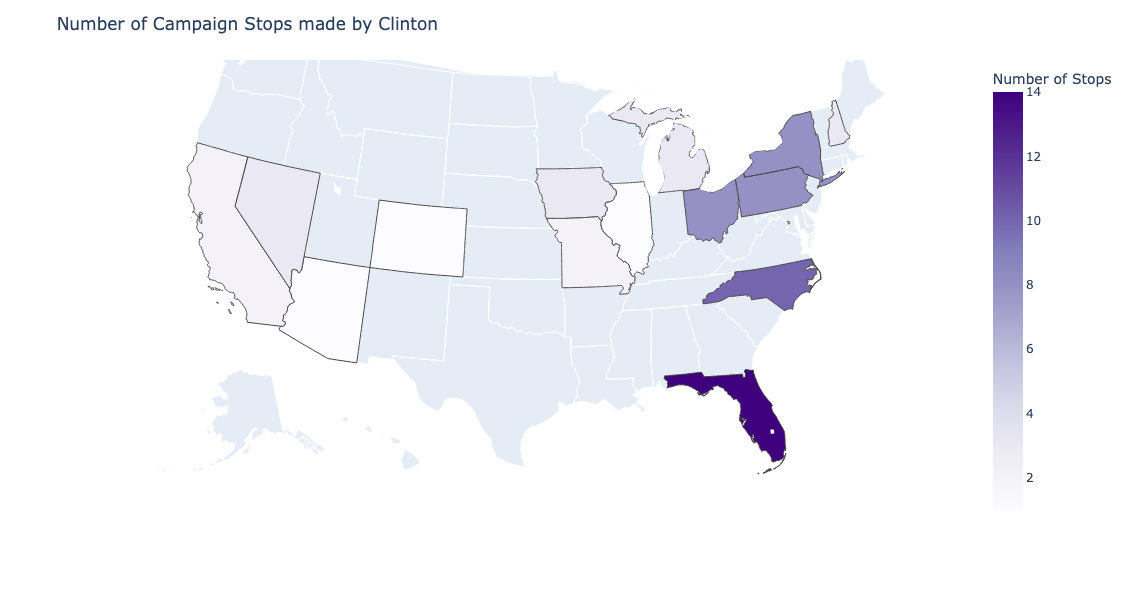

In [35]:
fig = px.choropleth(
    use,
    geojson=usa,
    locations=usa.GEO_ID,
    featureidkey="properties.GEO_ID",
    color="num_stops",
    hover_data={"NAME":True,"num_stops":True},
    color_continuous_scale="Purples"
)
fig.update_layout(
    title_text="Number of Campaign Stops made by Clinton",             
    coloraxis_colorbar=dict(title="Number of Stops"),                 
    height=600, width=800,
    geo=dict(
        scope="usa",
        projection=go.layout.geo.Projection(type='albers usa'),
    ),
)

fig.update_geos(fitbounds="locations", visible=True)
fig.show()

### Remapping with Overlay
- Addition of the overlay allows the viewer to see where in each state the stops are occurring. This is important because it shows that most of the stops are occurring in large cities.

In [45]:
m = use.explore(
    column= "norm",
    tooltip=["NAME","norm"],
    scheme='NaturalBreaks',
    k=5,
    cmap='Blues',
    style_kwds=dict(color="black"),  
    name='US States'
)

tour.explore(
    m=m,
    name = "Tesla charging stations"
)

folium.LayerControl().add_to(m)
m

## Reflection: 
- One of the main focuses of this assignment was to emphasize the significance of the specific places that Clinton chose to go. The base layer of the map, showing the proportion of trips each state received shows the viewer which states were deemed the most important by the Clinton campaign. These states are unsurprisingly swing states and ones with a great importance otherwise. Then, looking at the dots showing the specific stops, the viewer can see how important the state was based on how spread out the locations are. The spread of locations within a state, or lack thereof, allows the viewer to make conclusions about how important it was to the campaign to interact with people from all parts of the state. This data is slightly limited because it only includes information on one campaign. It could be stronger if there were multiple campaigns included, allowing for a more detailed analysis.